In [1]:
import os
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, losses
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow import keras
import cv2
import pandas as pd
from shutil import copyfile
from random import randint
import matplotlib.image as mpimg
import pandas as pd

In [2]:
src_dir  = "../input/trafficsign/"
train_dir = "/kaggle/input/trafficsign/Train"
test_dir = "./Dataset/Test/"

height = 30
width = 30
channels = 3
batchSize=32

In [3]:
# Load Tests And Validations
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(height,width),
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(height,width),
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
# Crate Model
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(height,width,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [5]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
# Train Model
history = model.fit(train_generator,epochs=10, validation_data=val_generator, batch_size=batchSize)

Epoch 1/10
981/981 [==============================] - 153s 155ms/step - loss: 0.9839 - accuracy: 0.7604 - val_loss: 0.2110 - val_accuracy: 0.9360
Epoch 2/10
981/981 [==============================] - 71s 72ms/step - loss: 0.0528 - accuracy: 0.9849 - val_loss: 0.1969 - val_accuracy: 0.9434
Epoch 3/10
981/981 [==============================] - 71s 72ms/step - loss: 0.0336 - accuracy: 0.9905 - val_loss: 0.3072 - val_accuracy: 0.9185
Epoch 4/10
981/981 [==============================] - 70s 72ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.1580 - val_accuracy: 0.9552
Epoch 5/10
981/981 [==============================] - 70s 71ms/step - loss: 0.0313 - accuracy: 0.9902 - val_loss: 0.1499 - val_accuracy: 0.9614
Epoch 6/10
981/981 [==============================] - 71s 72ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.2176 - val_accuracy: 0.9429
Epoch 7/10
981/981 [==============================] - 70s 71ms/step - loss: 0.0259 - accuracy: 0.9916 - val_loss: 0.1218 - val_accurac

In [7]:
# Load Test.csv And Copy Image base ClassId folders in new folders
df = pd.read_csv('../input/trafficsign/Test.csv')
!mkdir -p Dataset/Test

for i in tqdm(range(len(df))):
    if not os.path.exists(test_dir+str(df.iloc[i].ClassId)):
        os.makedirs(test_dir+str(df.iloc[i].ClassId))
    copyfile(src_dir+df.iloc[i].Path, test_dir+str(df.iloc[i].ClassId)+'/'+df.iloc[i].Path[5:])

100%|██████████| 12630/12630 [01:19<00:00, 159.46it/s]


In [8]:
# Load test Images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height,width),
    batch_size=batchSize,
    color_mode='rgb',    
    shuffle = False,
    seed=42,
    class_mode='categorical')

Found 12630 images belonging to 43 classes.


In [9]:
# predict Images
predict = model.predict(test_generator)
preds_classes = np.argmax(predict, axis=-1)

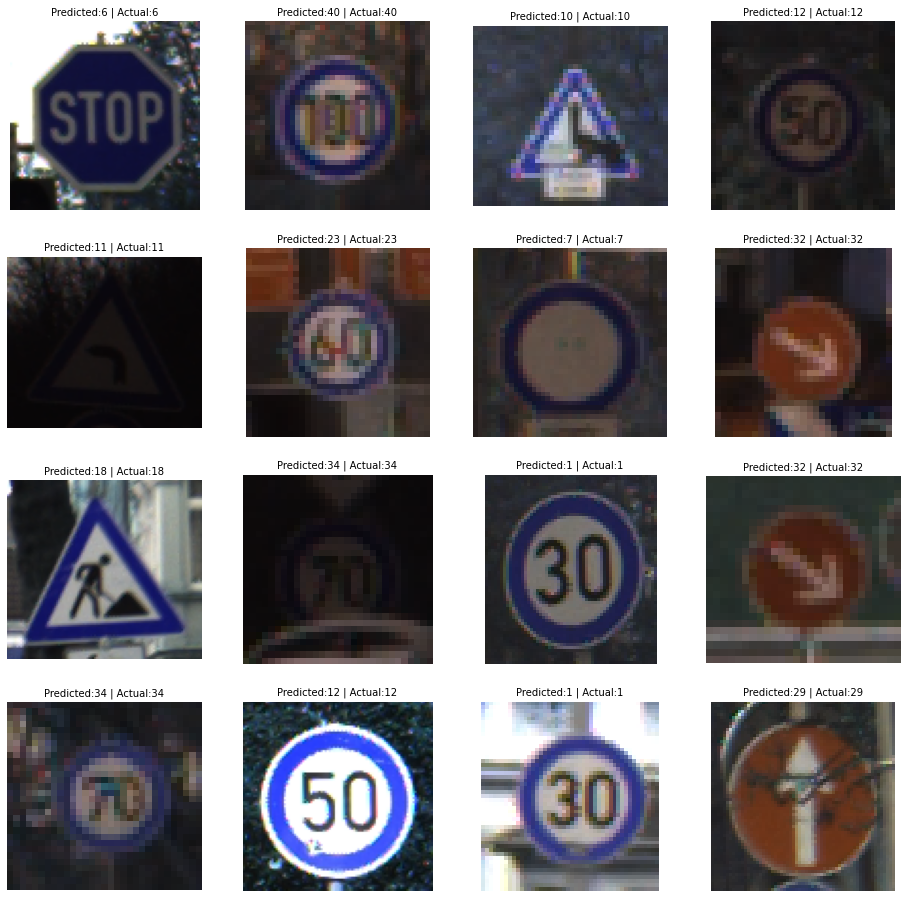

In [10]:
# Show images and labels and predicts
ncols=4
nrows=4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i in range(16):
    
    random=randint(0, len(test_generator.labels))
    prediction=preds_classes[random]
    img_path=test_generator.filepaths[random]
    
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    sp.set_title(f'Predicted:{prediction} | Actual:{test_generator.labels[random]}' ,fontsize=10)

    plt.imshow(cv2.cvtColor(mpimg.imread(img_path), cv2.COLOR_BGR2RGB))
    
plt.show()

In [11]:
# Save Model
model.save('CNN.h5')